# Mapping and Analysis of Toronto Schools

## Project Description
This notebook analyzes the distribution and attributes of schools across the  City of Toronto. The data includes school type, board affiliation, education level, and geographic location.

Using Python's data science stack and geospatial tools, we perform exploratory data analysis, classification, mapping, and visualization to uncover insights relevant for urban education and infrastructure.

## Project Goals
- Clean and preprocess school data
- Classify schools by level and board type
- Explore geographic distribution across Toronto districts
- Visualize school density and patterns
- Create interactive maps for spatial storytelling

## Data Loading & Initial Exploration

We begin by importing essential libraries and loading the raw dataset `school_locations.csv`, which contains information about schools across Toronto. This includes attributes such as school name, type, educational level of the institution, board affiliation, location details, and geographic data for mapping.

We then display the first few rows of the dataset and perform a quick data check to understand:
- Structure and number of columns
- Total records
- Data types of each column
- Presence of missing values (absolute count and percentage per column)

This initial overview helps identify key fields for analysis and sets the foundation for data cleaning and classification.

In [60]:
# Import necessary libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster, HeatMap
import ast

# Load dataset
df = pd.read_csv('data/school_locations.csv')
df.head()

,_id,OBJECTID,GEO_ID,NAME,SCHOOL_LEVEL,SCHOOL_TYPE,BOARD_NAME,SOURCE_ADDRESS,SCHOOL_TYPE_DESC,ADDRESS_POINT_ID,...,CITY,PLACE_NAME,GENERAL_USE_CODE,CENTRELINE_ID,LO_NUM,LO_NUM_SUF,HI_NUM,HI_NUM_SUF,LINEAR_NAME_ID,geometry
0,1,1,524780,A R S ARMENIAN PRIVATE SCHOOL,NaN,PR,NaN,50 HALLCROWN PL,Private,524780,...,NY,NaN,115001,438652,50,NaN,NaN,NaN,5778,"{""coordinates"": [[-79.323156147744, 43.7700530..."
1,2,2,517961,A Y JACKSON SECONDARY SCHOOL,NaN,EP,Toronto District School Board,50 FRANCINE DR,English Public,517961,...,NY,A. Y. Jackson Secondary School,115001,436260,50,NaN,NaN,NaN,5639,"{""coordinates"": [[-79.3665552934095, 43.805261..."
2,3,3,8594190,ABACUS MONTESSORI,NaN,PR,NaN,2723 ST CLAIR AVE E,Private,8594190,...,EY,Church Of St Columba and All,115001,8594192,2723,NaN,NaN,NaN,339,"{""coordinates"": [[-79.31007931829, 43.70574354..."
3,4,4,9602784,ABU HURAIRA ISLAMIC CENTRE AND ACADEMY,NaN,PR,NaN,270 YORKLAND BLVD,Private,9602784,...,NY,NaN,115001,30121150,270,NaN,NaN,NaN,7150,"{""coordinates"": [[-79.3345356762113, 43.772824..."
4,5,5,996700,ACACIA INTERNATIONAL HIGH SCHOOL,NaN,PR,NaN,235 DIXON RD,Private,996700,...,ET,NaN,115001,908498,235,NaN,NaN,NaN,1470,"{""coordinates"": [[-79.5439123761529, 43.696679..."


In [2]:
# Dataset overview
print("Data Shape:", df.shape)
print("\nDataset Info:\n")
df.info()

# Missing value analysis
missing_values = df.isnull().sum()
missing_pct = (missing_values / len(df)) * 100
print("\nMissing Values:\n", missing_values)
print("\nMissing Percentage (%):\n", round(missing_pct, 2))

Data Shape: (1171, 25)

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171 entries, 0 to 1170
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               1171 non-null   int64  
 1   OBJECTID          1171 non-null   int64  
 2   GEO_ID            1171 non-null   int64  
 3   NAME              1171 non-null   object 
 4   SCHOOL_LEVEL      0 non-null      float64
 5   SCHOOL_TYPE       1128 non-null   object 
 6   BOARD_NAME        814 non-null    object 
 7   SOURCE_ADDRESS    1171 non-null   object 
 8   SCHOOL_TYPE_DESC  1128 non-null   object 
 9   ADDRESS_POINT_ID  1171 non-null   int64  
 10  ADDRESS_NUMBER    1171 non-null   object 
 11  LINEAR_NAME_FULL  1171 non-null   object 
 12  ADDRESS_FULL      1171 non-null   object 
 13  POSTAL_CODE       1157 non-null   object 
 14  MUNICIPALITY      1171 non-null   object 
 15  CITY              1171 non-null   object 
 16  PLA

## Data Cleaning & Feature Engineering

We classify school levels and board names based on available fields, clean duplicated entries, and handle missing values.

In [3]:
# Detect school level using keywords from school names
def detect_school_level(name):
    name = str(name).upper()
    
    if 'MIDDLE SCHOOL' in name or 'MDL SCHOOL' in name or 'JUNIOR HIGH SCHOOL' in name:
        return 'Middle'
    elif 'SENIOR PUBLIC SCHOOL' in name or 'SR PUBLIC SCHOOL' in name or 'INTERMEDIATE SCHOOL' in name:
        return 'Middle'
    elif 'ELEMENTARY' in name or 'MONTESSORI' in name or 'JR' in name or 'ACADEMY' in name or 'PUBLIC SCHOOL' in name:
        return 'Elementary'
    elif 'ELEMENTAIRE' in name or 'ACADEMIE' in name or 'COMMUNITY SCHOOL' in name or 'JR SCHOOL' in name:
        return 'Elementary'
    elif 'SECONDARY' in name or 'HIGH SCHOOL' in name or 'ALTERNATIVE' in name:
        return 'High'
    elif 'SECONDAIRE' in name or 'COLLEGIATE' in name or 'TECHNICAL' in name:
        return 'High'
    elif 'COLLEGE' in name or 'UNIVERSITY' in name or 'U OF T' in name or 'YORK U' in name or 'TMU' in name:
        return 'Post-secondary'
    else:
        return 'Others'

df['SCHOOL_LEVEL'] = df['SCHOOL_LEVEL'].fillna(df['NAME'].apply(detect_school_level))
df.head(10)

# Fill missing board names based on school type
def detect_board_name(school_type):
    if school_type == 'PR':
        return 'Private'

df['BOARD_NAME'] = df['BOARD_NAME'].fillna(df['SCHOOL_TYPE'].apply(detect_board_name))

# Checking the result
df.head()

,_id,OBJECTID,GEO_ID,NAME,SCHOOL_LEVEL,SCHOOL_TYPE,BOARD_NAME,SOURCE_ADDRESS,SCHOOL_TYPE_DESC,ADDRESS_POINT_ID,...,CITY,PLACE_NAME,GENERAL_USE_CODE,CENTRELINE_ID,LO_NUM,LO_NUM_SUF,HI_NUM,HI_NUM_SUF,LINEAR_NAME_ID,geometry
0,1,1,524780,A R S ARMENIAN PRIVATE SCHOOL,Others,PR,Private,50 HALLCROWN PL,Private,524780,...,NY,NaN,115001,438652,50,NaN,NaN,NaN,5778,"{""coordinates"": [[-79.323156147744, 43.7700530..."
1,2,2,517961,A Y JACKSON SECONDARY SCHOOL,High,EP,Toronto District School Board,50 FRANCINE DR,English Public,517961,...,NY,A. Y. Jackson Secondary School,115001,436260,50,NaN,NaN,NaN,5639,"{""coordinates"": [[-79.3665552934095, 43.805261..."
2,3,3,8594190,ABACUS MONTESSORI,Elementary,PR,Private,2723 ST CLAIR AVE E,Private,8594190,...,EY,Church Of St Columba and All,115001,8594192,2723,NaN,NaN,NaN,339,"{""coordinates"": [[-79.31007931829, 43.70574354..."
3,4,4,9602784,ABU HURAIRA ISLAMIC CENTRE AND ACADEMY,Elementary,PR,Private,270 YORKLAND BLVD,Private,9602784,...,NY,NaN,115001,30121150,270,NaN,NaN,NaN,7150,"{""coordinates"": [[-79.3345356762113, 43.772824..."
4,5,5,996700,ACACIA INTERNATIONAL HIGH SCHOOL,High,PR,Private,235 DIXON RD,Private,996700,...,ET,NaN,115001,908498,235,NaN,NaN,NaN,1470,"{""coordinates"": [[-79.5439123761529, 43.696679..."


In [4]:
# Remove duplicated schools by name and geographic ID
df_cleaned = df.drop_duplicates(subset=['NAME'])
df_cleaned = df_cleaned.drop_duplicates(subset=['GEO_ID'])

# Drop columns with >95% missing values
missing_ratio = df_cleaned.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > 0.95].index
df_cleaned = df_cleaned.drop(columns=cols_to_drop)

# Fill missing categorical fields with 'Unknown' — these values were either not provided or failed to load during data collection
cols_to_fill = ['SCHOOL_TYPE', 'BOARD_NAME', 'SCHOOL_TYPE_DESC', 'POSTAL_CODE', 'PLACE_NAME']
df_cleaned[cols_to_fill] = df_cleaned[cols_to_fill].fillna('Unknown')

# Checking the result
missing_values = df_cleaned.isnull().sum()
print("\nMissing Values:\n", missing_values)


Missing Values:
 _id                 0
OBJECTID            0
GEO_ID              0
NAME                0
SCHOOL_LEVEL        0
SCHOOL_TYPE         0
BOARD_NAME          0
SOURCE_ADDRESS      0
SCHOOL_TYPE_DESC    0
ADDRESS_POINT_ID    0
ADDRESS_NUMBER      0
LINEAR_NAME_FULL    0
ADDRESS_FULL        0
POSTAL_CODE         0
MUNICIPALITY        0
CITY                0
PLACE_NAME          0
GENERAL_USE_CODE    0
CENTRELINE_ID       0
LO_NUM              0
LINEAR_NAME_ID      0
geometry            0
dtype: int64


# Data Visualization

This section presents visual insights into Toronto’s school data using various plotting techniques. We explore patterns in school levels and geographic distribution to better understand educational coverage across the city.

### Crosstab of Board Name vs. School Level

This summary table shows the number of schools per education level within each board. It complements visual charts with exact values for reference.

In [46]:
pd.crosstab(df_cleaned['BOARD_NAME'], df_cleaned['SCHOOL_LEVEL'])

SCHOOL_LEVEL,Elementary,High,Middle,Others,Post-secondary
BOARD_NAME,,,,,
Conseil scolaire Viamonde,10,1,0,0,0
Conseil scolaire de district catholique Centre-Sud,6,2,0,0,0
Private,122,23,1,137,21
Toronto Catholic District School Board,172,18,2,15,11
Toronto District School Board,358,86,84,44,0
Unknown,1,1,0,0,41


### School Level Distribution

We visualize how schools are distributed by educational level (e.g. Elementary, Middle, High). This helps assess representation across the city's school system.

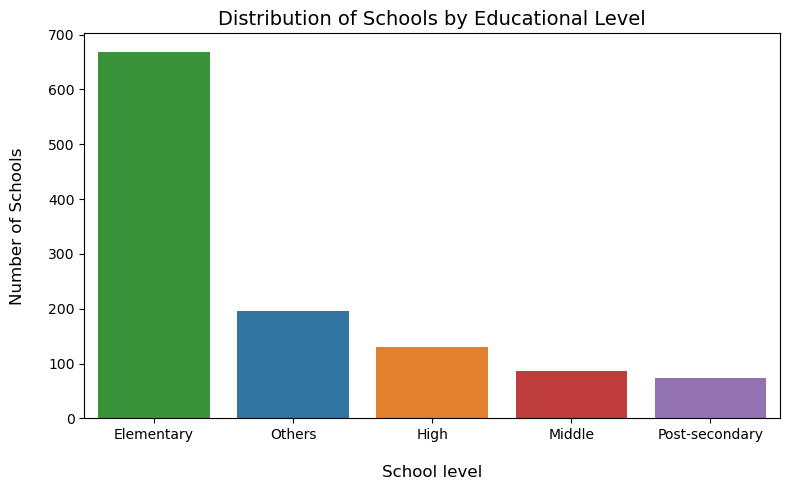

In [38]:
plt.figure(figsize=(8,5))

sns.countplot(
    x='SCHOOL_LEVEL',
    hue='SCHOOL_LEVEL',
    data=df_cleaned,
    order=df_cleaned['SCHOOL_LEVEL'].value_counts().index,
    palette='tab10',
    legend=False
)

plt.title('Distribution of Schools by Educational Level', fontsize=14)
plt.xlabel('\nSchool level', fontsize=12)
plt.ylabel('Number of Schools\n', fontsize=12)

plt.savefig('visuals/school_level_bar.png', bbox_inches='tight')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

This chart shows that elementary schools dominate Toronto’s educational landscape, with around 650 institutions. Middle and high schools are far fewer, and post-secondary schools make up the smallest group.

The “Others” category includes specialized institutions such as art schools, technical, and educational centers for adults, as well as private schools not formally classified.

**Note:** Some elementary schools extend to grades 7–8, overlapping with middle school levels. This partly explains the low number of separate middle schools, but also complicates classification accuracy.

### School Level Pie Chart

We use a pie chart to visualize the percentage breakdown of school levels across the dataset, highlighting how each category — such as elementary, middle, high, post-secondary, and others — contributes to the overall educational landscape in Toronto.

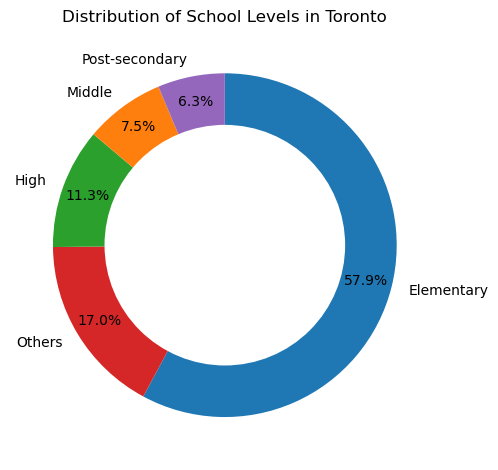

In [65]:
df_cleaned['SCHOOL_LEVEL'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    pctdistance=0.85,
    )

plt.title("Distribution of School Levels in Toronto")
plt.ylabel('')
plt.gca().set_aspect('equal')

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.savefig('visuals/school_level_pie.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

### School Board Distribution

We visualize the number of schools managed by each board (e.g. TDSB, Catholic, Private). It offers insight into how educational institutions are managed across the city.

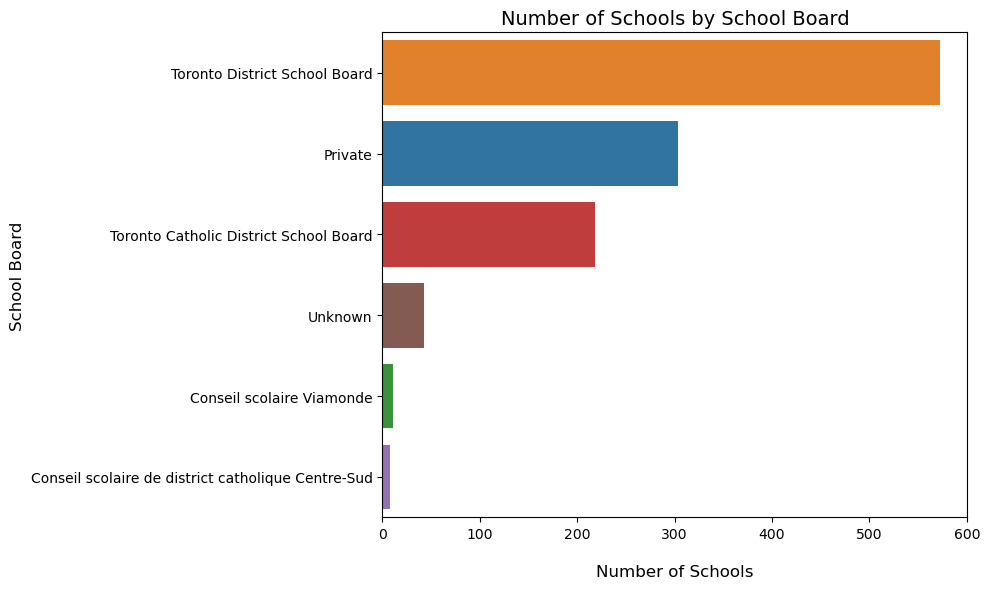

In [40]:
plt.figure(figsize=(10,6))
sns.countplot(
    y='BOARD_NAME',
    hue='BOARD_NAME',
    data=df_cleaned,
    order=df_cleaned['BOARD_NAME'].value_counts().index,
    palette='tab10',
    legend=False
)

plt.title('Number of Schools by School Board', fontsize=14)
plt.xlabel('\nNumber of Schools', fontsize=12)
plt.ylabel('School Board', fontsize=12)
plt.savefig('visuals/school_board_bar.png', bbox_inches='tight')

plt.tight_layout()
plt.show()

**Analysis:** This bar chart reveals the distribution of schools across various school boards in Toronto. The Toronto District School Board leads with the largest number of schools, followed by Private institutions and the Toronto Catholic District School Board. Francophone boards and those with unspecified data make up smaller portions. This visualization highlights the dominant presence of public education providers and the diversity of governance within the city's school system.

### Stacked Bar Chart of Education Level by School Board

We use a stacked bar chart to display how different education levels are distributed across school boards. This helps identify board specialization or bias toward certain levels.

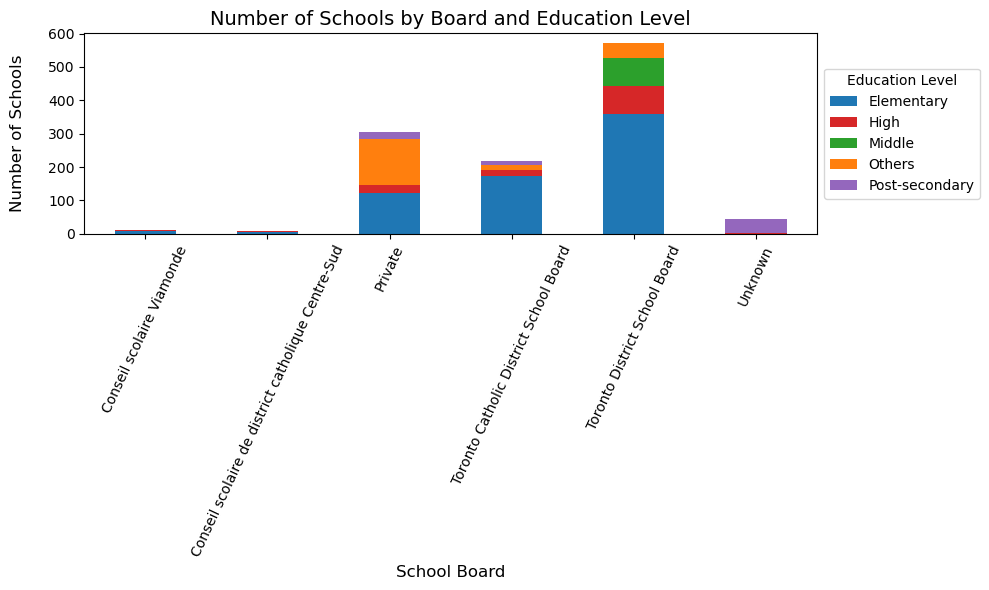

In [41]:
cross_tab = pd.crosstab(df_cleaned['BOARD_NAME'], df_cleaned['SCHOOL_LEVEL'])

ax = cross_tab.plot(
    kind='bar',
    stacked=True,
    figsize=(10,6),
    color=colors_bright
)

plt.legend(
    title='Education Level',
    loc='center left',
    bbox_to_anchor=(1.0, 0.5)
)

plt.title('Number of Schools by Board and Education Level', fontsize=14)
plt.xlabel('School Board', fontsize=12)
plt.ylabel('Number of Schools\n', fontsize=12)
plt.xticks(rotation=65)
plt.savefig('visuals/level_and_board_bar.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

**Analysis:**
This chart illustrates the distribution of schools of various levels — elementary, middle, secondary, other, and post-secondary — across Toronto’s educational boards. It reveals not only the number of institutions each board oversees, but also the extent of their involvement at different stages of the education system.

Most elementary and secondary schools fall under the Toronto District School Board and the Toronto Catholic District School Board, while private institutions exhibit broader presence across all levels, including post-secondary. Francophone boards are represented with fewer schools overall, suggesting more localized or specialized governance.

### Heatmap of Board vs. Level

To further explore the relationship between school types and governance, we can use a heatmap to visualize the distribution of schools by education level across Toronto’s school boards. This approach highlights patterns that might not be immediately visible in raw tables, helping to identify where certain types of institutions are concentrated.

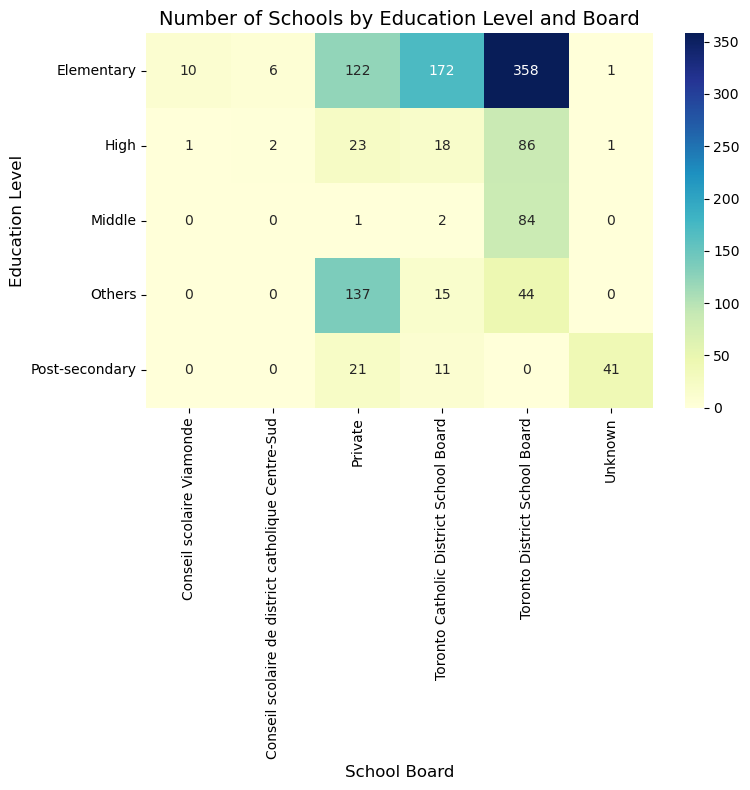

In [42]:
cross_tab2 = pd.crosstab(df_cleaned['SCHOOL_LEVEL'], df_cleaned['BOARD_NAME'])

plt.figure(figsize=(8,8))

sns.heatmap(
    cross_tab2,
    annot=True,
    fmt='d',
    cmap='YlGnBu'
)

plt.title('Number of Schools by Education Level and Board', fontsize=14)
plt.xlabel('School Board', fontsize=12)
plt.ylabel('Education Level', fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.savefig('visuals/level_and_board_heat.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

**Analysis:** Like in the earlier crosstab, this heatmap reveals clear trends — for example, certain boards have a higher concentration of elementary schools, while others focus more on secondary or post-secondary institutions. The darker shades point to the most common combinations, making differences between boards immediately apparent.

### Distribution by City District

This chart shows how schools are distributed across Toronto city districts. It helps identify geographic concentration and potential service gaps.

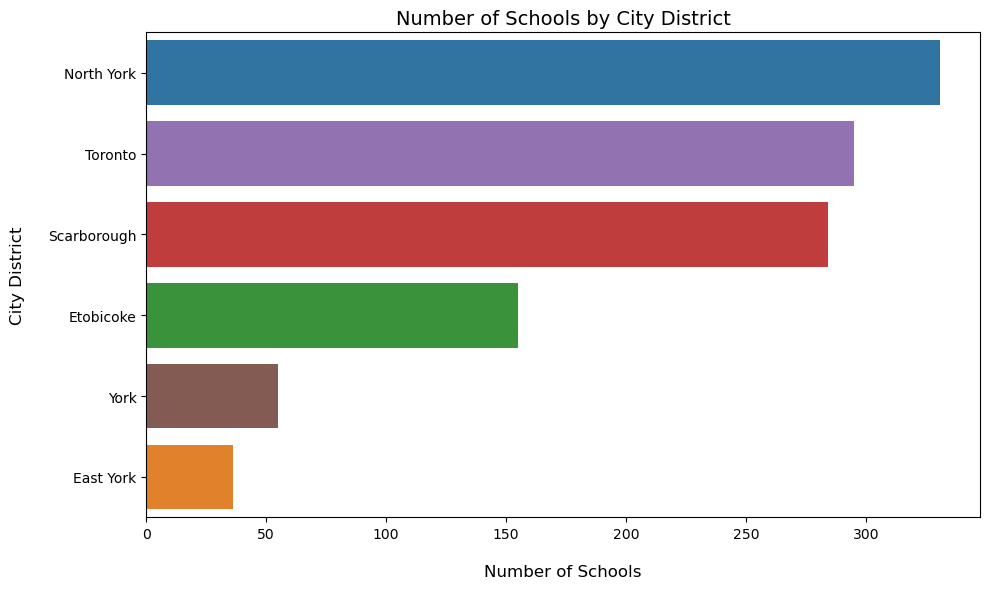

In [44]:
city_mapping = {
    'NY': 'North York',
    'SC': 'Scarborough',
    'ET': 'Etobicoke',
    'TO': 'Toronto',
    'EY': 'East York',
    'YK': 'York'
}

df_cleaned['CITY'] = df_cleaned['CITY'].replace(city_mapping)

plt.figure(figsize=(10,6))
sns.countplot(
    y='CITY',
    hue='CITY',
    data=df_cleaned,
    order=df_cleaned['CITY'].value_counts().index,
    palette='tab10',
    legend=False
)

plt.title("Number of Schools by City District", fontsize=14)
plt.xlabel("\nNumber of Schools", fontsize=12)
plt.ylabel("City District\n", fontsize=12)
plt.savefig('visuals/city_district_bar.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

**Analysis:** North York and Scarborough have the largest number of schools—an expected outcome given that they also occupy the largest geographical areas in Toronto. Toronto (Central) follows closely due to its dense urban profile. Meanwhile, East York and York have far fewer schools, which corresponds with their much smaller land area. So while the overall distribution appears uneven at first glance, it aligns more reasonably when district size is taken into account.

### School Type Description Pie Chart

We visualize the distribution of descriptive school types using a pie chart with slight emphasis (explode) on special categories, particularly to improve visibility of smaller percentages.

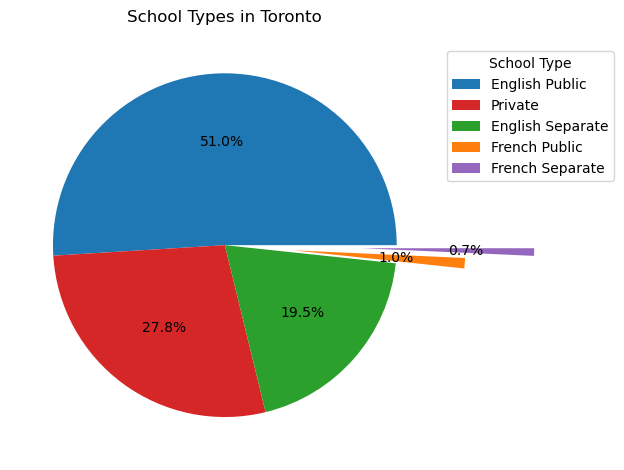

In [45]:
type_counts = df['SCHOOL_TYPE_DESC'].value_counts()
labels = type_counts.index

type_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    labels=None,
    explode=[0, 0, 0, 0.4, 0.8]
)

plt.title("School Types in Toronto")
plt.ylabel('')  # hide y-axis label
plt.legend(labels, title='School Type', loc='center left', bbox_to_anchor=(1.0, 0.8))

plt.tight_layout()
plt.savefig('visuals/school_type_pie.png', bbox_inches='tight')
plt.show()

**Analysis:** English Public schools form the largest portion (51%), followed by Private schools (27.8%) and English Separate schools (19.5%). French Public and Separate schools make up only a small share (under 2%), indicating that Toronto’s education system is predominantly English and public, with notable diversity through private and faith-based options.

## Visualizing School Locations in Toronto

In this section, we explore spatial data of schools in Toronto using two visualization techniques:

- **Matplotlib + GeoPandas** for static plotting  
- **Folium** for creating interactive web-based maps

### Static Map with GeoPandas and Matplotlib

A simple map showing where schools are located across Toronto, based on their geographic coordinates.

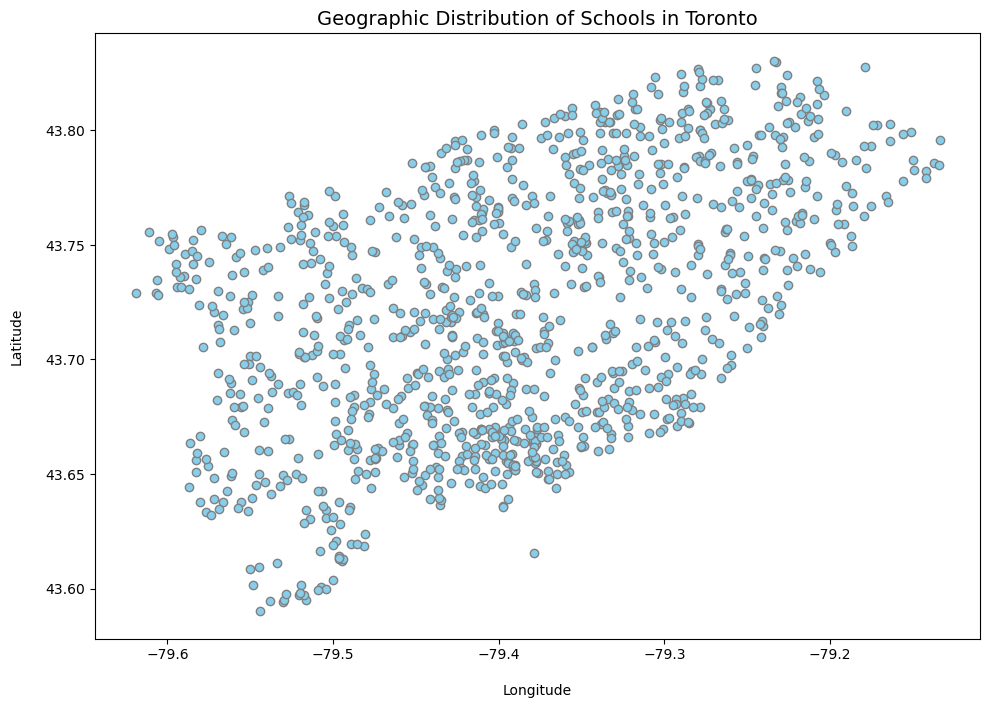

In [54]:
# Parse geometry string into dictionary
df_cleaned['geometry'] = df_cleaned['geometry'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Extract coordinates
df_cleaned['Longitude'] = df_cleaned['geometry'].apply(lambda g: g['coordinates'][0][0])
df_cleaned['Latitude'] = df_cleaned['geometry'].apply(lambda g: g['coordinates'][0][1])

# Create shapely Point geometry
df_cleaned['geometry_point'] = df_cleaned.apply(
    lambda row: Point(row['Longitude'], row['Latitude']), axis=1
)

# Convert to GeoDataFrame with proper CRS
gdf = gpd.GeoDataFrame(df_cleaned, geometry='geometry_point', crs='EPSG:4326')

# Plot map
ax = gdf.plot(figsize=(10,8), color='skyblue', edgecolor='grey')
ax.set_title('Geographic Distribution of Schools in Toronto', fontsize=14)
ax.set_xlabel('\nLongitude')
ax.set_ylabel('Latitude\n')
plt.savefig("visuals/toronto_schools_map.png", dpi=100)
plt.tight_layout()
plt.show()

**Analysis:** At first glance, schools in Toronto appear unevenly distributed across the city — some areas show clear clustering, while others are noticeably sparse. This initial overview offers a general sense of educational accessibility, but lacks precision at the neighborhood level.

To explore this further, we’ll build an interactive map using Folium that allows for deeper analysis of exact school locations and local concentration patterns.

### Interactive School Map in Toronto Using Folium
In this section, we create an interactive map showing school locations across Toronto using the Folium library.
Each marker on the map represents a school. When schools are close together, the markers are grouped into clusters to keep the map clear and easy to explore, especially in densely populated areas.

In [57]:
# Initialize the map centered over Toronto
m = folium.Map(location=[43.7, -79.4], zoom_start=11)

# Create a marker cluster to group nearby schools
marker_cluster = MarkerCluster().add_to(m)

# Add a marker for each school
for _, row in df_cleaned.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],  # Extracted coordinates
        tooltip=row['NAME'],                           # Tooltip shown on hover
        popup=f"<b>{row['NAME']}</b><br>Level: {row['SCHOOL_LEVEL']}<br>Type: {row['BOARD_NAME']}"  # Info shown on click
    ).add_to(marker_cluster)

# Display and save the map
m.save('visuals/toronto_schools_interactive_map.html')
m

### School Density Heatmap Using Folium
In this section, we create a heatmap to visualize school density across Toronto. Unlike standard marker maps, the heatmap highlights areas with a higher concentration of schools through color intensity, making it easier to identify clusters and high-density zones in the city.

In [59]:
# Prepare coordinate data for heatmap
heat_data = [[row['Latitude'], row['Longitude']] for _, row in df_cleaned.iterrows()]

# Initialize map centered on Toronto
m = folium.Map(location=[43.7, -79.4], zoom_start=11)

# Add heatmap layer
HeatMap(heat_data, radius=12, blur=18, max_zoom=1).add_to(m)

# Display and save map
m.save('visuals/toronto_schools_heatmap.html')
m

### Analysis of the School Density Map in Toronto
This heat map visualizes the spatial distribution of schools across the Toronto area, using color gradients to indicate density. Areas with higher concentrations of schools appear in green and yellow, while blue and purple zones reflect lower density. 

__1. Spatial Distribution__
- Central Toronto neighborhoods—especially Midtown, the University district, and parts of Downtown—show a high concentration of educational institutions. This reflects historical urban development, dense housing, and strong demand for schooling.
- Peripheral areas such as Scarborough, Etobicoke, and North York exhibit lower school density, likely due to lower population density, larger residential plots, and fewer multi-unit dwellings.

__2. Transportation Accessibility__
- High school density near subway lines and major transit corridors (e.g., Yonge Street, Bloor Street) suggests a strong correlation between transit access and school placement.
- Areas with limited public transit options tend to have fewer schools, which may pose accessibility challenges for students, particularly those from low-income households.

__3. Socio-Economic Context__
- Neighborhoods with higher socio-economic status (e.g., Rosedale, Forest Hill) host numerous private schools.
- In ethnically diverse and lower-income communities (e.g., Flemingdon Park, Jane-Finch), school density may be lower despite a greater need for educational services, indicating a potential mismatch between infrastructure and community needs.

__4. Urban Planning & Development__
- The map serves as a valuable tool for municipal planning, helping identify areas where new schools or expansions are needed.
- It also provides insight into educational equity: whether children across different neighborhoods have equal access to quality education.

### Conclusions
- Central Toronto has the highest school density, aligned with population concentration, transit infrastructure, and historical development.

- Outer neighborhoods require strategic attention, especially those with growing immigrant populations and younger demographics.

- Integrating this map with demographic, socio-economic, and transit data would enable a more nuanced understanding of educational accessibility and equity across the city.